In [ ]:
import pandas as pd
import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

import os

In [2]:
finished_paths = pd.read_csv("data/processed/clean_finished_paths.csv")
unfinished_paths = pd.read_csv("data/processed/clean_unfinished_paths.csv")

print(finished_paths.shape)
print(unfinished_paths.shape)

(28403, 14)
(33538, 15)


In [3]:
popular_pairs = unfinished_paths.groupby(["source", "target"]).size().reset_index(name="count")
most_popular_pairs = popular_pairs.sort_values("count", ascending=False).head(50)

most_popular_pairs.head(5)

,source,target,count
13349,Pyramid,Bean,1888
16191,Theatre,Zebra,1744
1499,Asteroid,Viking,1454
2826,Brain,Telephone,1004
2074,Batman,Wood,150


# Shortest Path Computation

In [4]:
def compute_shortest_path(source, target, graph):
    try:
        shortest_path = nx.shortest_path(graph, source=source, target=target)
        return shortest_path
    except nx.NetworkXNoPath:
        return None

In [5]:
links = pd.read_csv("data/wikispeedia_paths-and-graph/links.tsv", sep="\t", skiprows= 11, names = ["source", "target"])
graph = nx.from_pandas_edgelist(links, source="source", target="target", create_using=nx.DiGraph)

most_popular_pairs["shortest_path"] = most_popular_pairs.apply(lambda r: compute_shortest_path(r["source"], r["target"], graph), axis=1)

most_popular_pairs.head(5)

,source,target,count,shortest_path
13349,Pyramid,Bean,1888,"[Pyramid, California, Fruit, Bean]"
16191,Theatre,Zebra,1744,"[Theatre, India, Extinction, Zebra]"
1499,Asteroid,Viking,1454,"[Asteroid, 1_Ceres, Paris, Viking]"
2826,Brain,Telephone,1004,"[Brain, Biology, 19th_century, Telephone]"
2074,Batman,Wood,150,"[Batman, Chemistry, Fire, Wood]"


# Links coordinates

In [46]:
cache = {}

def get_article_html_path(article_name):
    return os.path.abspath("data/wpcd/wp/{}/{}.htm".format(article_name[0].lower(), article_name))

def get_path_links_coordinates(browser, articles, cache):
    path_links_coords = []
    for i in range(len(articles) - 1):
        cur_article = articles[i]
        next_article = articles[i+1]
        if cur_article == "<":
            continue
        if cur_article in cache and next_article in cache[cur_article]:
            path_links_coords.extend(cache[cur_article][next_article])
            print("Cache hit for {} -> {}".format(cur_article, next_article))
            continue
        
        local_html_file = get_article_html_path(cur_article)

        print("Opening file: ", local_html_file)
        browser.get("file:///" + local_html_file)
        
        next_url = "../../wp/{}/{}.htm".format(next_article[0].lower(), next_article)

        links = browser.find_elements(By.XPATH, "//a[@href=\"{}\"]".format(next_url))
        links_coords = [(link.location["x"], link.location["y"]) for link in links] # if many links are found we take all their coordinates

        if cache.get(cur_article) is None:
            cache[cur_article] = {}
        cache[cur_article][next_article] = links_coords

        path_links_coords.extend(links_coords)
    
    return path_links_coords

In [35]:
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--window-size=1920,1080")

browser = webdriver.Chrome(options=chrome_options)

In [38]:
most_popular_pairs["links_coords"] = most_popular_pairs["shortest_path"].apply(lambda p: get_path_links_coordinates(browser, p, cache))

Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\p\Pyramid.htm | SUCCESS
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\c\California.htm | SUCCESS
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\f\Fruit.htm | SUCCESS
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\t\Theatre.htm | SUCCESS
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\i\India.htm | SUCCESS
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\e\Extinction.htm | SUCCESS
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\a\Asteroid.htm | SUCCESS
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\1\1_Ceres.htm | SUCCESS
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\p\Paris.htm | SUCCESS
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\b\Brain.htm | SUCCESS
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\b\Biology.htm | SUCCESS


In [41]:
most_popular_pairs.head(5)

,source,target,count,shortest_path,links_coords
13349,Pyramid,Bean,1888,"[Pyramid, California, Fruit, Bean]","[(711, 1506), (801, 2526), (124, 868)]"
16191,Theatre,Zebra,1744,"[Theatre, India, Extinction, Zebra]","[(269, 2214), (224, 2255), (144, 2198), (433, ..."
1499,Asteroid,Viking,1454,"[Asteroid, 1_Ceres, Paris, Viking]","[(217, 157), (1801, 435), (1230, 325), (985, 3..."
2826,Brain,Telephone,1004,"[Brain, Biology, 19th_century, Telephone]","[(349, 421), (84, 1213), (38, 6883)]"
2074,Batman,Wood,150,"[Batman, Chemistry, Fire, Wood]","[(1258, 1617), (405, 743), (448, 1907)]"


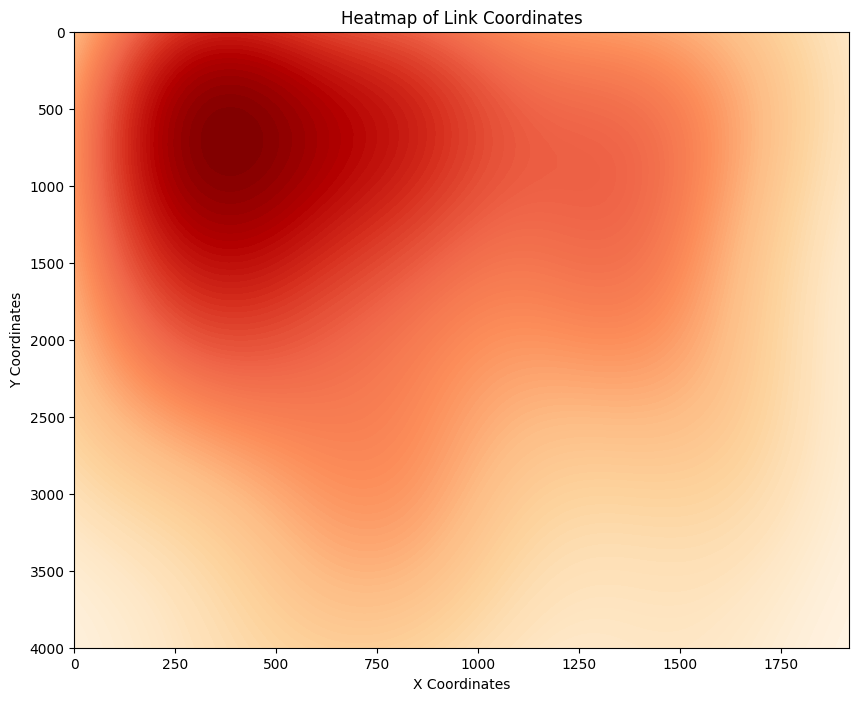

In [67]:
all_links_coords = []
for links_coords in most_popular_pairs["links_coords"].values:
    all_links_coords.extend(links_coords)

x_coords = [coord[0] for coord in all_links_coords]
y_coords = [coord[1] for coord in all_links_coords]

plt.figure(figsize=(10, 8))
sns.kdeplot(x=x_coords, y=y_coords, fill=True, thresh=0, levels=100, cmap="OrRd")
plt.xlim(0, 1920)
plt.ylim(0, 4000)
plt.gca().invert_yaxis()
plt.title("Heatmap of Link Coordinates")
plt.xlabel("X Coordinates")
plt.ylabel("Y Coordinates")
plt.show()

In [50]:
popular_pairs_set = set(zip(most_popular_pairs['source'], most_popular_pairs['target']))
filtered_unfinished_paths = unfinished_paths[unfinished_paths.apply(lambda row: (row['source'], row['target']) in popular_pairs_set, axis=1)]
filtered_unfinished_paths = filtered_unfinished_paths.drop_duplicates(subset=["hashedIpAddress", "timestamp"])
filtered_unfinished_paths.shape

(4489, 15)

In [51]:
filtered_unfinished_paths["links_coords"] = filtered_unfinished_paths["path"].apply(eval).apply(lambda p: get_path_links_coordinates(browser, p, cache))

Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\c\Calculus.htm
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\p\Physics.htm
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\p\Physical_science.htm
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\c\Chicken.htm
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\c\China.htm
Cache hit for Economics -> Education
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\e\Education.htm
Cache hit for Technology -> Electronics
Cache hit for Theatre -> Stage_%28theatre%29
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\s\Stage_%28theatre%29.htm
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\i\Italian_Renaissance.htm
Cache hit for Brain -> Philosophy_of_mind
Cache hit for Philosophy_of_mind -> <
Cache hit for Cell_%28biology%29 -> <
Cache hit for Pyramid -> Mexico
Cache hit for Mexico -> Agriculture
Cache hit 

In [54]:
filtered_unfinished_paths.to_csv("filtered_unfinished_paths.csv", index=False)

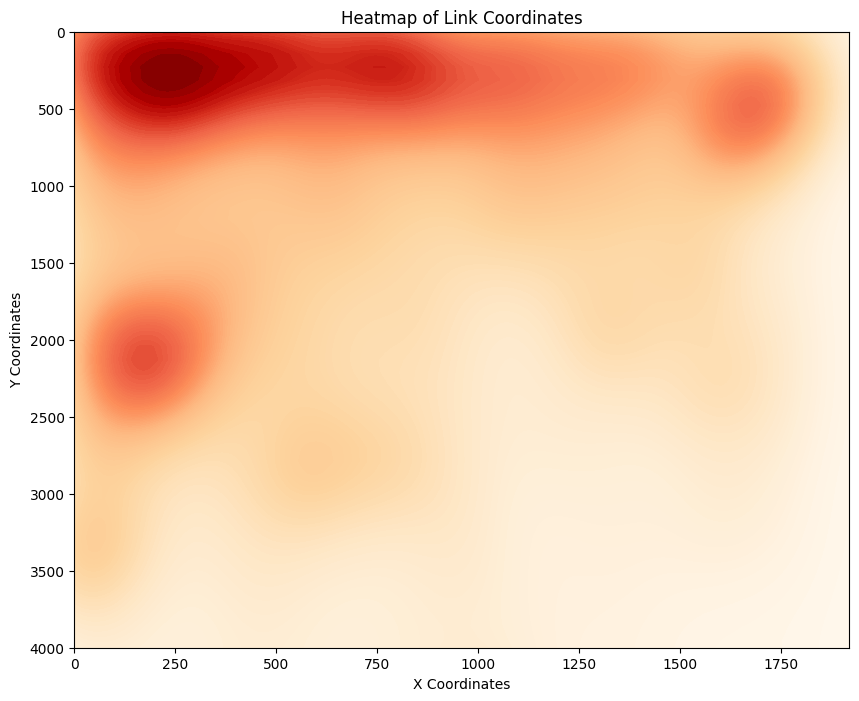

In [ ]:
all_links_coords = []
for links_coords in filtered_unfinished_paths["links_coords"].values:
    all_links_coords.extend(links_coords)

x_coords = [coord[0] for coord in all_links_coords]
y_coords = [coord[1] for coord in all_links_coords]

plt.figure(figsize=(10, 8))
sns.kdeplot(x=x_coords, y=y_coords, cmap="OrRd", fill=True, thresh=0, levels=100)
plt.xlim(0, 1920)
plt.ylim(0, 4000)
plt.gca().invert_yaxis()
plt.title("Heatmap of Link Coordinates")
plt.xlabel("X Coordinates")
plt.ylabel("Y Coordinates")
plt.show()

In [47]:
popular_pairs_set = set(zip(most_popular_pairs['source'], most_popular_pairs['target']))
filtered_finished_paths = finished_paths[finished_paths.apply(lambda row: (row['source'], row['target']) in popular_pairs_set, axis=1)]
filtered_finished_paths = filtered_finished_paths.drop_duplicates(subset=["hashedIpAddress", "timestamp"])
filtered_finished_paths.shape

(1846, 14)

In [48]:
filtered_finished_paths["links_coords"] = filtered_finished_paths["path"].apply(eval).apply(lambda p: get_path_links_coordinates(browser, p, cache))

Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\1\14th_century.htm
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\t\Time.htm
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\i\Isaac_Newton.htm
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\l\Light.htm
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\c\Color.htm
Cache hit for 14th_century -> Time
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\t\Time.htm
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\l\Light.htm
Cache hit for 14th_century -> Time
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\t\Time.htm
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\s\Science.htm
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\n\Nature.htm
Opening file:  d:\EPFL\MA1\ADA\ada-2024-project-tadaa\data\wpcd\wp\w\Weather.htm
Opening file:  d:\EPFL\MA1\ADA\ada-2024-proje

In [55]:
filtered_finished_paths.to_csv("filtered_finished_paths.csv", index=False)

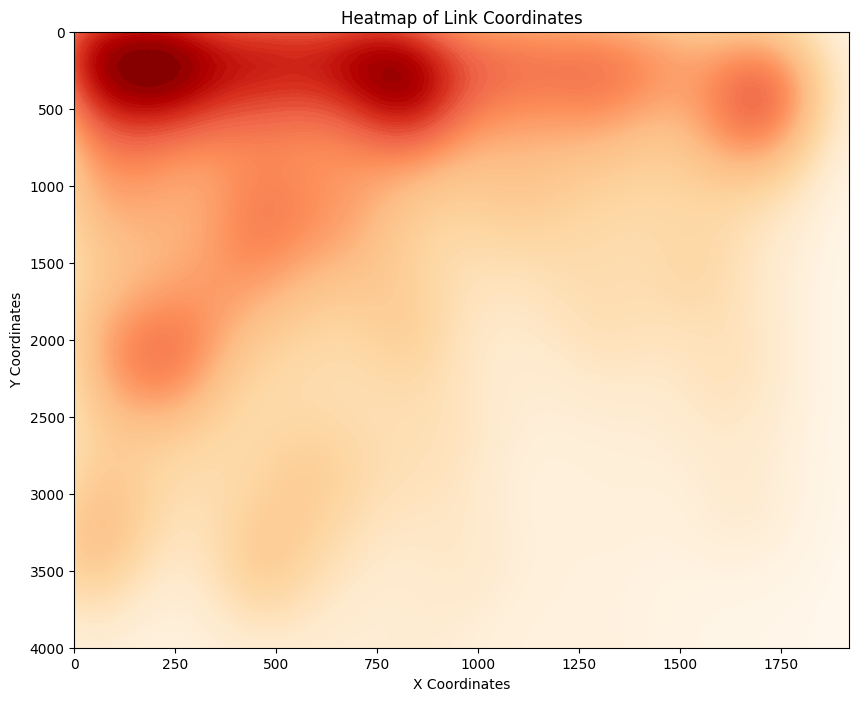

In [ ]:
all_links_coords = []
for links_coords in filtered_finished_paths["links_coords"].values:
    all_links_coords.extend(links_coords)

x_coords = [coord[0] for coord in all_links_coords]
y_coords = [coord[1] for coord in all_links_coords]

plt.figure(figsize=(10, 8))
sns.kdeplot(x=x_coords, y=y_coords, cmap="OrRd", fill=True, thresh=0, levels=100)
plt.xlim(0, 1920)
plt.ylim(0, 4000)
plt.gca().invert_yaxis()
plt.title("Heatmap of Link Coordinates")
plt.xlabel("X Coordinates")
plt.ylabel("Y Coordinates")
plt.show()

In [34]:
browser.quit()